## 09.06.2023 ROC, k-nearest neighbour, decision trees and random forests

Copyright (C) 2023, B. Zeller-Plumhoff

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html) for more details.

This Jupyter Notebook was created by Berit Zeller-Plumhoff for the course "Data Science for Material Scientists" at Kiel University. 

Within the notebook, you will perform a classification of metallicity using logistic regression, $k$-nearest neighbours and decision trees. Varying the $k$ and depth of the tree, you will assess how these influence your results and compare the performance of the different classifiers using ROC metrics and curves.

<span style='color:red'> 02.06.2023: You will also include random forests classifiers in this notebook this week. </span>

<span style='color:red'> 09.06.2023: You will also include support vector machine classifiers in this notebook this week. </span>

We begin by loading the required libraries.

In [1]:
import pandas as pd # library for organizing data
import numpy as np # library for numerial computations
from sklearn import linear_model # the linear_model library establishes a straightforward implementation of a linear regression model
from sklearn.model_selection import train_test_split, KFold, cross_val_score # this library enables the splitting of a data set into training and test data
from sklearn.inspection import DecisionBoundaryDisplay # library to display decision boundaries of classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, RocCurveDisplay, roc_curve, roc_auc_score, log_loss, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt # library for plotting (not interactive)
import matminer.datasets as mm # library for data mining materials properties, accesses published datasets
from matminer.featurizers.conversions import StrToComposition # converts a string denoting a material composition into the composition
from matminer.featurizers.composition.element import ElementFraction # determines the element fraction for a given composition
from pymatgen.core import Composition # materials analysis library, module used to analyse the chemical composition of a compound

### Predicting metallicity

For classification of metallicit based on the material compositon, we will use the dataset based on the publication from [Zhuo et al., 2018](https://pubs.acs.org/doi/pdf/10.1021/acs.jpclett.8b00124)<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) that can be accessed through __matminer__. Have a look at last week's notebook to learn more about the dataset and __matminer__.

In this case, we will start by loading the pickle file which we prepared previously.

In [2]:
df=pd.read_pickle('ismetal_df.pkl')
df.head()

,formula,is_metal,composition,H,He,Li,Be,B,C,N,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,Ag(AuS)2,True,"(Ag, Au, S)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Ag(W3Br7)2,True,"(Ag, W, Br)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Ag0.5Ge1Pb1.75S4,False,"(Ag, Ge, Pb, S)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Ag0.5Ge1Pb1.75Se4,False,"(Ag, Ge, Pb, Se)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Ag2BBr,True,"(Ag, B, Br)",0.0,0,0.0,0.0,0.25,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Assign the dataframe __without__ columns "formula" "is_metal" and "composition" to your feature variable X and the "is_metal" column to the observation y. Then split this data into training and test data.

In [3]:
# assign the variables
X=df.drop(["formula","is_metal","composition"],axis=1)
y=df["is_metal"]

# split your data sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Now we will sort the data we created above using different algorithms. To do so, use the train data to fit and the test data to predict the classifiers. Do this by employing the [__logistic regression__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), the [__k-nearest neighbors__](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), and the [__decision tree__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) classification methods. In the case of classification using __k-nearest neighbors__, we will make predictions considering different numbers of nearest neighbors. The same will be done for the __decision tree__ and the maximum depth of the tree. This can be performed within a loop, where you will __append__ the current model and predictions to a list thereof, which will initially be empty. For the loop, consider the range from $\left[1, 20\right]$. Read the documentation for these methods if necessary. 

<span style='color:red'> 02.06.2023: add the [__random forest__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#) classifier, looping over the number of estimators to include in the ensemble from $\left[1, 100\right]$ in steps of 10. </span>

<span style='color:red'> 09.06.2023: add the [__support vector machine__](https://scikit-learn.org/stable/modules/svm.html#classification) classifier(s) according to the specification developed in the original paper (try setting the parameters as given in the paper or not). </span>

In [4]:
# logistic regression
model_log_reg = linear_model.LogisticRegression()
model_log_reg=model_log_reg.fit(X_train, y_train)
y_pred_log_reg = model_log_reg.predict(X_test)

# k-nearest neighbors (loop over k)
model_knn=[]
y_pred_knn=[]
for k in range(1,21):
    model_knn_tmp = KNeighborsClassifier(n_neighbors=k)
    model_knn.append(model_knn_tmp.fit(X_train, y_train))
    y_pred_knn.append(model_knn_tmp.predict(X_test))

# decision tree (loop over max_depth)
model_tree=[]
y_pred_tree=[]
for i in range(1,21):
    model_tree_tmp = DecisionTreeClassifier(max_depth=i)
    model_tree.append(model_tree_tmp.fit(X_train, y_train))
    y_pred_tree.append(model_tree_tmp.predict(X_test))
    
# random forests (loop over n_estimators in steps of 50, i.e. 1, 50, 100, 150...)
model_rf=[]
y_pred_rf=[]
model_rf_tmp = RandomForestClassifier(n_estimators=1) 
model_rf.append(model_rf_tmp.fit(X_train, y_train))
y_pred_rf.append(model_rf_tmp.predict(X_test))
for j in range(10,110,10):
    model_rf_tmp = RandomForestClassifier(n_estimators=j) 
    model_rf.append(model_rf_tmp.fit(X_train, y_train))
    y_pred_rf.append(model_rf_tmp.predict(X_test))
    
model_svm_lin=SVC(kernel='linear',C=32,gamma=0.01,probability=True)
model_svm_lin.fit(X_train,y_train)
y_pred_svm_lin=model_svm_lin.predict(X_test)

model_svm_pol=SVC(kernel='poly',C=32,gamma=0.01,probability=True)
model_svm_pol.fit(X_train,y_train)
y_pred_svm_pol=model_svm_pol.predict(X_test)

model_svm_rbf=SVC(kernel='rbf',C=32,gamma=0.01,probability=True)
model_svm_rbf.fit(X_train,y_train)
y_pred_svm_rbf=model_svm_rbf.predict(X_test)



In [5]:
model_svm_rbf=SVC(kernel='rbf',probability=True)
model_svm_rbf.fit(X_train,y_train)
y_pred_svm_rbf=model_svm_rbf.predict(X_test)

### Confusion matrices

Now that we have made our predictions with the different classifiers, we are interested in checking the generalization performance of our models. This will be done using the [__confusion matrix__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay). To do this, use the metrics module in the scikit library to create confusion matrices for our train and test data. Build confusion matrices for the three types of classifiers used above. You can also observe what happens when you consider different numbers of neighbors (for the k-nearest neighbors) and different tree depths (for the decision tree). What can you conclude from these different results?

<span style='color:red'> 02.06.2023: Add the confusion matrices for the random forests with different numbers of estimators too. How do they behave in comparison to the other classifiers? </span>

<span style='color:red'> 09.06.2023: Add the confusion matrices for the SVM. How do they behave in comparison to the other classifiers? </span>

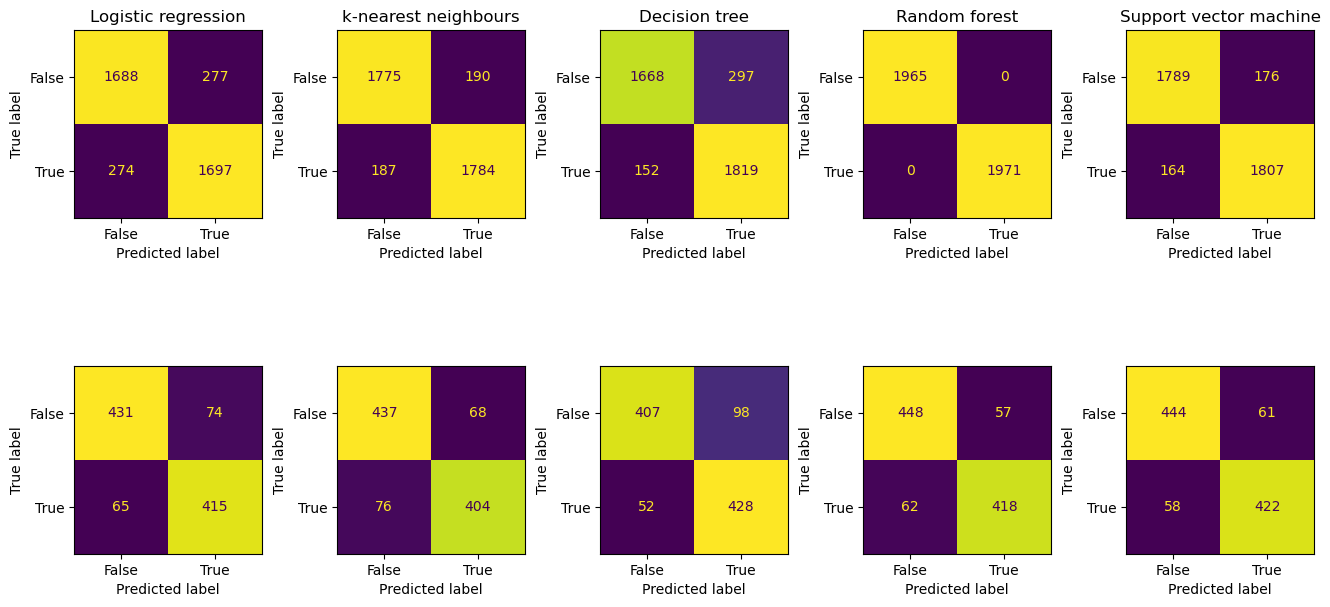

In [6]:
# display the confusion matrices in one figure as three subplots in two rows, one for training and one for testing data
k=5
depth=10
n_est=100
norm_meth=None

# display the confusion matrices in one figure as three subplots in two rows, one for training and one for testing data
fig,ax=plt.subplots(2,5, figsize=(16,8))
plt.subplots_adjust(wspace=0.4)
cm_display_log_reg = ConfusionMatrixDisplay.from_estimator(model_log_reg,X_train,y_train, normalize=norm_meth, colorbar=False,ax=ax[0][0])
ax[0][0].set_title('Logistic regression')
cm_display_knn = ConfusionMatrixDisplay.from_estimator(model_knn[k-1],X_train,y_train, normalize=norm_meth, colorbar=False,ax=ax[0][1])
ax[0][1].set_title('k-nearest neighbours')
cm_display_tree = ConfusionMatrixDisplay.from_estimator(model_tree[depth-1],X_train,y_train, normalize=norm_meth, colorbar=False,ax=ax[0][2])
ax[0][2].set_title('Decision tree')
cm_display_rf = ConfusionMatrixDisplay.from_estimator(model_rf[int(n_est/10)],X_train,y_train, normalize=norm_meth, colorbar=False,ax=ax[0][3])
ax[0][3].set_title('Random forest')
cm_display_svm = ConfusionMatrixDisplay.from_estimator(model_svm_rbf,X_train,y_train, normalize=norm_meth, colorbar=False,ax=ax[0][4])
ax[0][4].set_title('Support vector machine')

cm_display_log_reg = ConfusionMatrixDisplay.from_estimator(model_log_reg,X_test,y_test, normalize=norm_meth, colorbar=False,ax=ax[1][0])
cm_display_knn = ConfusionMatrixDisplay.from_estimator(model_knn[k-1],X_test,y_test, normalize=norm_meth, colorbar=False,ax=ax[1][1])
cm_display_tree = ConfusionMatrixDisplay.from_estimator(model_tree[depth-1],X_test,y_test, normalize=norm_meth, colorbar=False,ax=ax[1][2])
cm_display_rf = ConfusionMatrixDisplay.from_estimator(model_rf[int(n_est/10)],X_test,y_test, normalize=norm_meth, colorbar=False,ax=ax[1][3])
cm_display_svm = ConfusionMatrixDisplay.from_estimator(model_svm_rbf,X_test,y_test, normalize=norm_meth, colorbar=False,ax=ax[1][4])
plt.show()

#### Metrics

Based on the results obtained from the confusion matrices, we will build a panda datraframe to visualize the metrics obtained for our test data predictions. Its table should contain the following columns: 'Classifier', 'True negatives', 'False positives', 'False negatives', 'True positives', 'Positive predictive value', 'Negative predictive value', 'True positive rate', 'True negative rate', 'Log loss error', 'Accuracy', 'Area under the curve'. Do this for all four types of classifiers used. Read the documentation found in the [__sklearn.metrics.confusion_matrix__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) module if needed and search for the other metrics accordingly.

To start, you will need to initialize a dataframe with the column names and then use the __.loc__ function to add rows.

How do the numerical values compare to the confusion matrices you had displayed?

<span style='color:red'> 09.06.2023: Add the values for the SVM. How do they behave in comparison to the other classifiers? </span>

In [7]:
# set k and max_depth and n_estimators
k=20
depth=10
n_est=10

# initialize the pandas dataframe with the correct column names
df_metrics=pd.DataFrame(columns=['Classifier','True negatives', 'False positives', 'False negatives','True positives','Positive predictive value','Negative predictive value','True positive rate','True negative rate', 'Log loss error','Accuracy','Area under the curve'])

# compute the metrics for each classifier and add the corresponding rows to the dataframe
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log_reg).ravel()
df_metrics.loc[0]=['Logistic regression',tn,fp,fn,tp,tp/(tp+fp),tn/(fn+tn),tp/(tp+fn),tn/(fp+tn),log_loss(y_test, model_log_reg.predict_proba(X_test)),accuracy_score(y_test, y_pred_log_reg),roc_auc_score(y_test, model_log_reg.predict_proba(X_test)[:,1])]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn[k-1]).ravel()
df_metrics.loc[1]=['k-nearest neighbour',tn,fp,fn,tp,tp/(tp+fp),tn/(fn+tn),tp/(tp+fn),tn/(fp+tn),log_loss(y_test, model_knn[k-1].predict_proba(X_test)),accuracy_score(y_test, y_pred_knn[k-1]),roc_auc_score(y_test, model_knn[k-1].predict_proba(X_test)[:,1])]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree[depth-1]).ravel()
df_metrics.loc[2]=['Decision tree',tn,fp,fn,tp,tp/(tp+fp),tn/(fn+tn),tp/(tp+fn),tn/(fp+tn),log_loss(y_test, model_tree[depth-1].predict_proba(X_test)),accuracy_score(y_test, y_pred_tree[depth-1]),roc_auc_score(y_test, model_tree[depth-1].predict_proba(X_test)[:,1])]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf[int(n_est/10)]).ravel()
df_metrics.loc[3]=['Random Forest',tn,fp,fn,tp,tp/(tp+fp),tn/(fn+tn),tp/(tp+fn),tn/(fp+tn),log_loss(y_test, model_rf[int(n_est/10)].predict_proba(X_test)),accuracy_score(y_test, y_pred_rf[int(n_est/10)]),roc_auc_score(y_test, model_rf[int(n_est/10)].predict_proba(X_test)[:,1])]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm_rbf).ravel()
df_metrics.loc[4]=['SVM',tn,fp,fn,tp,tp/(tp+fp),tn/(fn+tn),tp/(tp+fn),tn/(fp+tn),log_loss(y_test, model_svm_rbf.predict_proba(X_test)),accuracy_score(y_test, y_pred_svm_rbf),roc_auc_score(y_test, model_svm_rbf.predict_proba(X_test)[:,1])]


# display the data frame
df_metrics

,Classifier,True negatives,False positives,False negatives,True positives,Positive predictive value,Negative predictive value,True positive rate,True negative rate,Log loss error,Accuracy,Area under the curve
0,Logistic regression,431,74,65,415,0.848671,0.868952,0.864583,0.853465,0.365794,0.858883,0.926609
1,k-nearest neighbour,446,59,106,374,0.863741,0.807971,0.779167,0.883168,0.624580,0.832487,0.918131
2,Decision tree,407,98,52,428,0.813688,0.886710,0.891667,0.805941,0.866930,0.847716,0.883123
3,Random Forest,454,51,76,404,0.887912,0.856604,0.841667,0.899010,0.652277,0.871066,0.942492
4,SVM,444,61,58,422,0.873706,0.884462,0.879167,0.879208,0.313267,0.879188,0.939674


#### ROC curves

Now we will use the ROC curves to analyze the performance of our classifiers for prediction. For this task you will need to calculate the probability estimate for all the binary classes of the model. See documentation for the methods predict_proba(...), roc_curve(...) and RocCurveDisplay(...).

1. First use the k-nearest neighbors classifier and plot the ROC curve for models where k = 1, 5, 9, 13, 17. How does the number of nearest neighbors influence the ROC curve? 

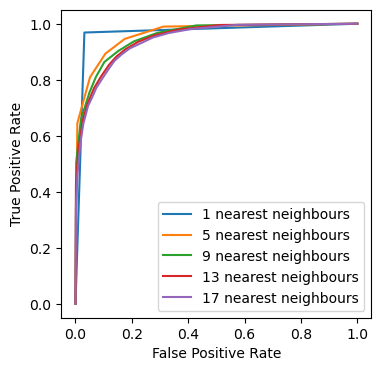

In [8]:
fig,ax=plt.subplots(figsize=(4,4))
for i in range(0,20,4):
    y_score_knn=model_knn[i].predict_proba(X_test)[:,1]
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
    roc_display_knn = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn).plot(ax,label='%s nearest neighbours' %(i+1))
plt.show()

2. Do the same thing for the decision tree classifier. How does the max_depth influences the ROC curves?

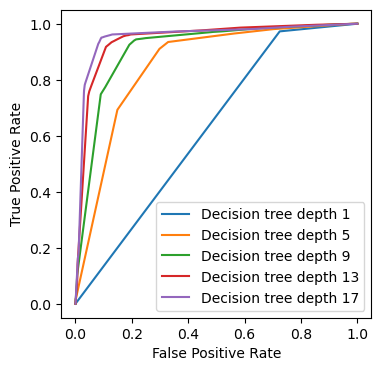

In [9]:
fig,ax=plt.subplots(figsize=(4,4))
for i in range(0,20,4):
    y_score_tree=model_tree[i].predict_proba(X_test)[:,1]
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_score_tree)
    roc_display_tree = RocCurveDisplay(fpr=fpr_tree, tpr=tpr_tree).plot(ax,label='Decision tree depth %s' %(i+1))
plt.show()

3. Similarly, display the ROC curve for the random forest classifier for different n_estimators. How does this variable influence the ROC curves?

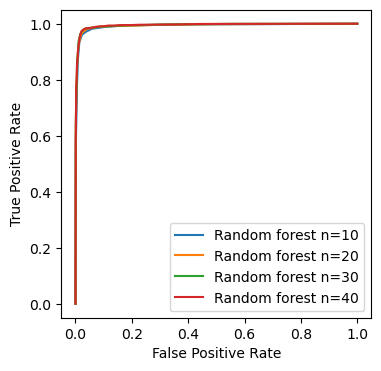

In [10]:
fig,ax=plt.subplots(figsize=(4,4))
for i in range(10,50,10):
    y_score_rf=model_rf[int(i/10)].predict_proba(X_test)[:,1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
    roc_display_rf = RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf).plot(ax,label='Random forest n=%s' %(int(i)))
plt.show()

4. Finally, plot the ROC curves for the logistic regression classifier, k-nearest neighbors classifier (for k = 5), the decision tree classifier (for max_depth = 11) and for the random forest classifier (n_estimators=100).  Of course, you can play with the model parameters or divide between testing and training performance. Which differences do you notice between the different  models?

<span style='color:red'> 09.06.2023: Add the ROC curve for the best performing SVM. How does it compare? </span>

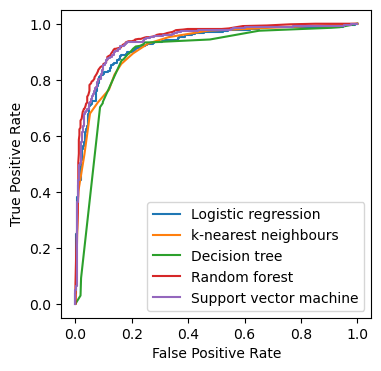

In [11]:
y_score_log_reg=model_log_reg.predict_proba(X_test)[:,1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_score_log_reg)
y_score_knn=model_knn[10].predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
y_score_tree=model_tree[10].predict_proba(X_test)[:,1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_score_tree)
y_score_rf=model_rf[10].predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
y_score_svm=model_svm_rbf.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)

fig,ax=plt.subplots(figsize=(4,4))
roc_displayog_reg = RocCurveDisplay(fpr=fpr_log_reg, tpr=tpr_log_reg).plot(ax,label='Logistic regression')
roc_display_knn = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn).plot(ax,label='k-nearest neighbours')
roc_display_tree = RocCurveDisplay(fpr=fpr_tree, tpr=tpr_tree).plot(ax,label='Decision tree')
roc_display_rf = RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf).plot(ax,label='Random forest')
roc_display_svm = RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot(ax,label='Support vector machine')
plt.show()

Overall, how do the ROC curves compare to the metrics you had displayed in the dataframe above?

Using the following cell, you can display the decision tree that you have trained. Run the code for different __max_depth__ and see how your tree changes. What do you conclude from the tree structure?

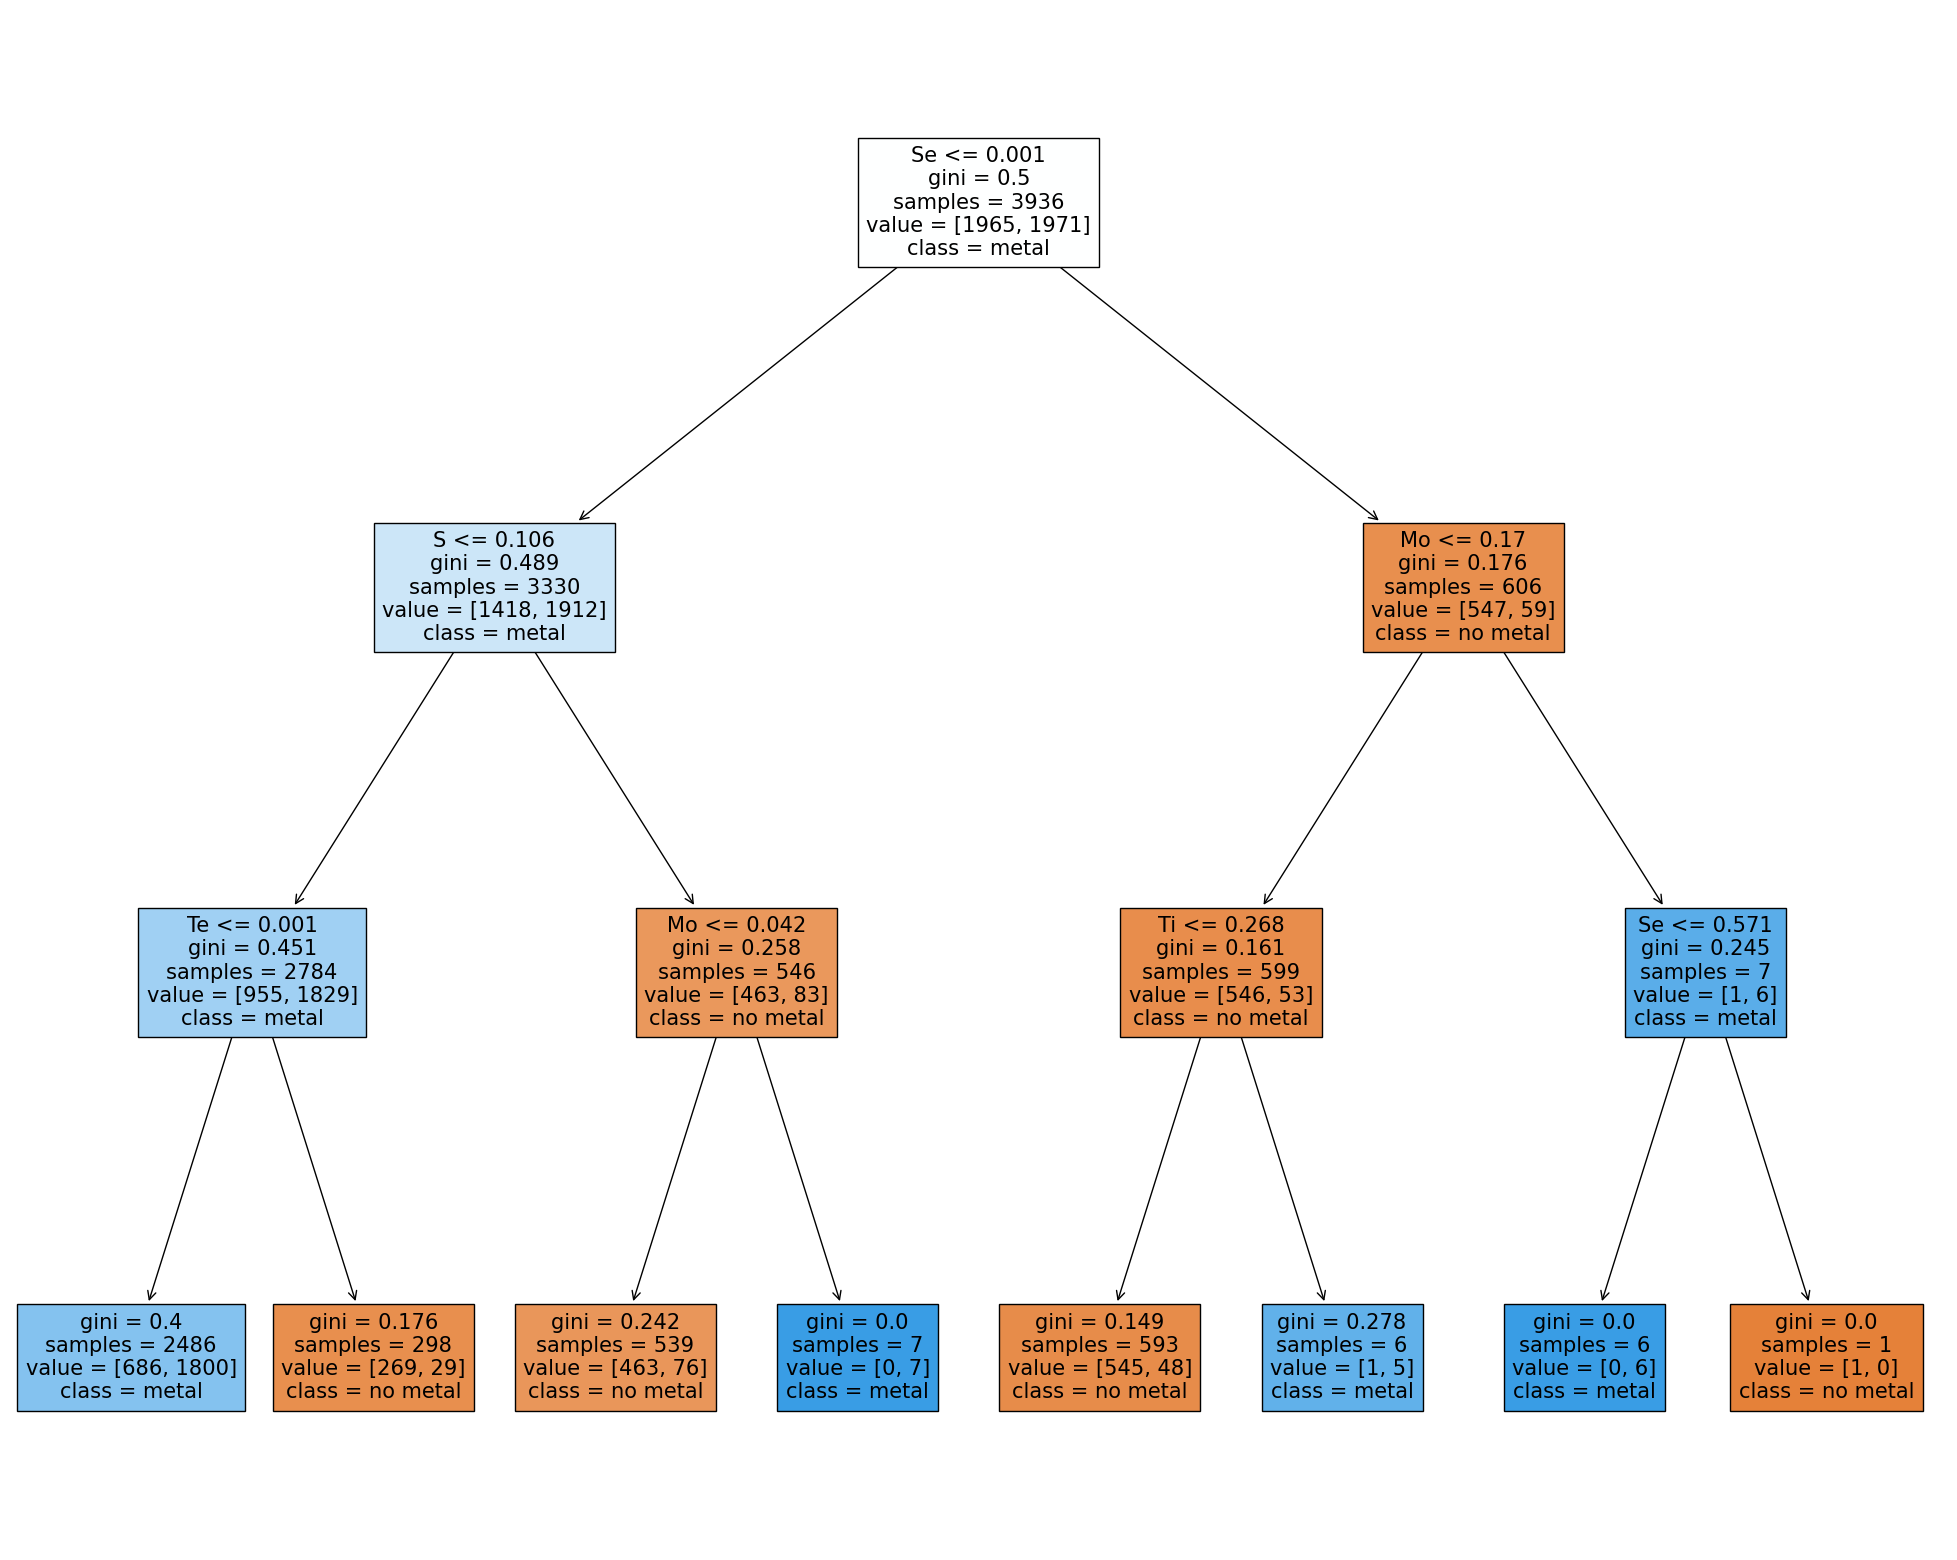

In [12]:
from sklearn import tree
clf=model_tree[2]
y_names=['no metal','metal']
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,  
                   feature_names=df.drop(["formula","is_metal","composition"],axis=1).columns, 
                   class_names=y_names,
                   filled=True)
#fig.savefig("decision_tree_depth%d.png" % i)

With trees and random forests we can determine the [__feature_importances__](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) in a straightforward manner. The following cell lets you compute the feature importances based on the mean decrease in Gini impurity for the random forests you have trained and plot them in descending order. How does this agree with the tree you plotted in the previous cell?

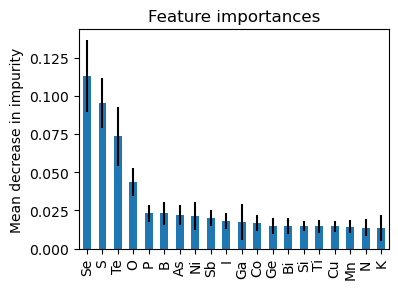

In [13]:
feature_names=df.drop(["formula","is_metal","composition"],axis=1).columns
importances = model_rf[2].feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf[2].estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
sorted_idx = (-importances).argsort()[:20]

fig, ax = plt.subplots(figsize=(4,3))
forest_importances[sorted_idx].plot.bar(yerr=std[sorted_idx], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

To compute the proximity matrix based on your random forests, use the following cell. The code was taken from [this stackoverflow entry](https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier). You can vary which random forest model you use and have a look at the resulting visualization of proximities.

In [14]:
# This code is taken from https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier
# which is available under a CC BY-SA 3.0 license, see here for more information: https://creativecommons.org/licenses/by-sa/3.0/ 

def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat   


pM=proximityMatrix(model_rf[2], X, normalize=True)

The proximity matrix $PM$ can be converted into a dissimilarity matrix $DM=1-PM$ and using multidimensional scaling, it can then be projected onto a 2D-plane, as described in [Gilles Louppe - Understanding Random Forests: From Theory to Practice](https://arxiv.org/abs/1407.7502).
To do so, we used the sklearn method [MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
and adapted the transformation and plotting routine described [here](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py). Execute the following two cells to visualize the proximities for our classes metals and non-metals. 

What does the result suggest?

In [15]:
from sklearn import manifold
transformer=manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=1, normalized_stress="auto")
transformer.dissimilarity_matrix_=(1-pM)

projections = transformer.fit_transform((1-pM))

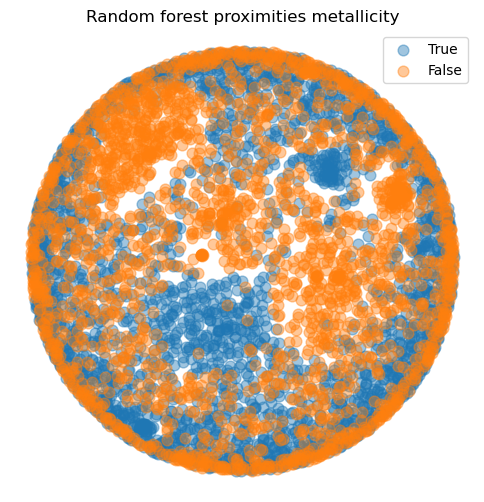

In [16]:
from sklearn.preprocessing import MinMaxScaler
def plot_embedding(XX, title):
    _, ax = plt.subplots(figsize=(6,6))
    XX = MinMaxScaler().fit_transform(XX)

    for ff in [True,False]:
        ax.scatter(
            *XX[y == ff].T,
            label=ff,
            s=60,
            alpha=0.425,
            zorder=2,
        )
    ax.legend()
    ax.set_title(title)
    ax.axis("off")

plot_embedding(projections,'Random forest proximities metallicity')

plt.show()

For comparison, you can run the cell below which will compute the proximity matrix and display the results for the digits data set shown in the lecture. This cell is adapted from [the scikit documentation](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), which is available under the BSD license (© 2007 - 2023, scikit-learn developers).

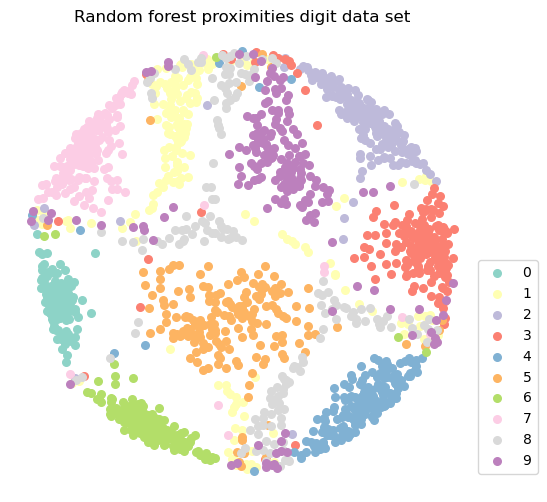

In [17]:
from sklearn.datasets import load_digits
def plot_embeddingd(Xd, title):
    _, ax = plt.subplots(figsize=(6,6))
    Xd = MinMaxScaler().fit_transform(Xd)

    for digit in digits.target_names:
        ax.scatter(
            *Xd[yd == digit].T,
            label=f"${digit}$",
            s=30,
            color=plt.cm.Set3(digit),
            zorder=2,
        )
    ax.legend(loc='lower right', bbox_to_anchor=(1.15, 0.025))
    ax.set_title(title)
    ax.axis("off")
    
digits = load_digits()
Xd, yd = digits.data, digits.target
n_samples, n_features = Xd.shape
rf_model=RandomForestClassifier(n_estimators=200)
rf_model.fit(Xd, yd)

pMd=proximityMatrix(rf_model, Xd, normalize=True)

transformerd=manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=1, normalized_stress="auto")
transformerd.dissimilarity_matrix_=(1-pMd)

projectionsd = transformerd.fit_transform((1-pMd))

plot_embeddingd(projectionsd,'Random forest proximities digit data set')

plt.show()

For the linear support vector machine, we can display the feature importance by sorting the linear coefficients of each feature by (absolute) value. Have a look at the plot below, which displays the first 20 features. 

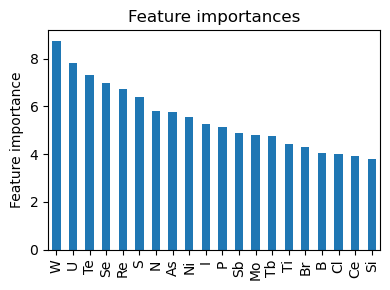

In [18]:
feature_names=np.array(df.drop(["formula","is_metal","composition"],axis=1).columns)

svm_importances = pd.Series(model_svm_lin.coef_[0], index=feature_names)
sorted_idx = np.absolute(model_svm_lin.coef_[0]).argsort()[::-1][:20]

fig, ax = plt.subplots(figsize=(4,3))
np.absolute(svm_importances[sorted_idx]).plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Feature importance")
fig.tight_layout()

This is not possible for kernels other than the linear one, as the separating hyperplane is in a different dimension than the original features. What you can do instead is to use __permutation importance__, similarly as for the random forest.

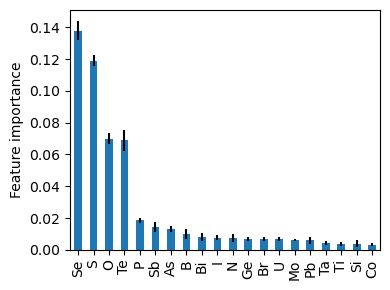

In [19]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_svm_rbf, X_test, y_test)
imp_mean=pd.Series(np.absolute(perm_importance.importances_mean), index=feature_names)
imp_std=pd.Series(perm_importance.importances_std, index=feature_names)

fig, ax = plt.subplots(figsize=(4,3))
sorted_idx = imp_mean.argsort()[::-1][:20]
imp_mean[sorted_idx].plot.bar(yerr=imp_std[sorted_idx], ax=ax)
ax.set_ylabel("Feature importance")
fig.tight_layout()

<a name="cite_note-1"></a>1.[^](#cite_ref-1) Y. Zhuo, A.M. Tehrani, and J. Brgoch, J. Phys. Chem. Lett. 2018, 9, 7, 1668–1673, https://doi.org/10.1021/acs.jpclett.8b00124

### 16.06.2023 Multilayer perceptron

In this part of the notebook you will implement a multilayer perceptron using the [__MLPClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#) to classify the metallicity dataset.

Begin by implementing the MLPClassifier using one hidden layer and looping over the number of nodes in that hidden layer, using numbers in the range of $\left[1, 103\right]$ - use an appropriate step size. Allow a maximum of 500 iterations. Set __random_state__ to 42 to ensure that your classifiers are generally comparable.

In [ ]:
# neural network (loop over number of nodes in hidden layers)


For the MLP classifiers that you trained, display the training loss at each iteration. How does the number of nodes in the hidden layer influence the training loss? Why do certain models not train until the maximum number of iterations that you had defined?

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))


Similarly, plot the accuracy of each MLP classifier against the number of nodes in the layer. What do you observe?

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))


Now that we have seen how the MLP classifier behaves if we have only one hidden layer with different numbers of nodes, we want to see how different numbers of hidden layers with a fixed number of nodes each behave. Define MLP classifiers looping over the number of hidden layers, selecting the number of of nodes that previously achieved the highest accuracy. Use up to 20 hidden layers.

In [ ]:
# neural network (loop over number of hidden layers)


Again, plot the (training) loss curve for the different numbers of hidden layers. What do you observe in this case? Why do certain models not train until the maximum number of iterations that you had defined?

Plot the accuracy against the number of hidden layers. What trend are you observing?

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))


Clearly, finding the optimal number of hidden layers and nodes per hidden layer it a difficult optimization problem that generally requires careful consideration. You can find extensive literature on the subject. To generally find the answer to this question for a specific problem, you need to perform a cross-validation and assess the test loss for varying numbers of hidden layers and nodes. However, there are some general rules that you can make use of, look for example [here](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) or [here](https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e). 

Therefore, using __KFold__ let's perform a 5-fold cross-valiadation computing the mean accuracy for different MLP classifiers with numbers of hidden layers being 1 or 2 and number of nodes per hidden layer being up to 10. For simplicity, we only allow the same number of nodes in the first and second hidden layer.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


Plot the mean accuracy as a function of the number of hidden layers and number of nodes per layer. which classifier performs best?

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
